<a href="https://colab.research.google.com/github/flaviowu/btc-c14-g4/blob/main/notebooks/modelo_regressao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('drive/MyDrive/Colab Notebooks/BTC-Dados-G4/train_raw.csv')


## Tratando dataset

In [3]:
df.head()

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2018-6-18,27
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,2018-3-18,15
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2018-10-25,14
3,3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2018-2-20,1
4,4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,2018-4-16,13


In [4]:
df = df.drop(['Unnamed: 0','train_id','brand_name', 'date'], axis=1)
df.head()

,name,item_condition_id,category_name,price,shipping,item_description,stock
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,10.0,1,No description yet,27
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,52.0,0,This keyboard is in great condition and works ...,15
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,10.0,1,Adorable top with a hint of lace and a key hol...,14
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,35.0,1,New with tags. Leather horses. Retail for [rm]...,1
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,44.0,0,Complete with certificate of authenticity,13


In [5]:
# dividindo as categorias em colunas
categories = df.category_name.str.split('/', expand=True)
categories.columns = ['main_cat', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']

df = pd.concat([df, categories], axis=1)
df.drop(['category_name', 'sub_cat_3', 'sub_cat_4'], axis=1, inplace=True)

df.columns

Index(['name', 'item_condition_id', 'price', 'shipping', 'item_description',
       'stock', 'main_cat', 'sub_cat_1', 'sub_cat_2'],
      dtype='object')

In [6]:
df.shape

(1482535, 9)

Verificando se existem valores faltantes dentro do dataset. O metodo info() será o primeiro passo para uma ideia geral dos dados do dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   price              1482535 non-null  float64
 3   shipping           1482535 non-null  int64  
 4   item_description   1482531 non-null  object 
 5   stock              1482535 non-null  int64  
 6   main_cat           1476208 non-null  object 
 7   sub_cat_1          1476208 non-null  object 
 8   sub_cat_2          1476208 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 101.8+ MB


Foram identificados algumas valores faltantes nas colunas de categoria. O metodo isna() junto com sum() irá mostrar a soma desses valores por coluna.

In [8]:
df.isna().sum()

name                    0
item_condition_id       0
price                   0
shipping                0
item_description        4
stock                   0
main_cat             6327
sub_cat_1            6327
sub_cat_2            6327
dtype: int64

Acho interessante focar em uma categoria para saber a proporção desses valores faltantes em relação ao numero total de linhas da coluna.

In [9]:
df['main_cat'].isna().value_counts(normalize = True).mul(100).round(1).astype(str) + '%' # Frequencias relativas

False    99.6%
True      0.4%
Name: main_cat, dtype: object

Observando a frequencia relativa dos valores faltantes da principal categoria, é notavel que existe uma proporção muito baixa em relação ao total. Será interessante olhar mais de perto as linhas que possuem esses dados faltantes.

In [10]:
valores_faltantes = df[df['main_cat'].isna()]
valores_faltantes



,name,item_condition_id,price,shipping,item_description,stock,main_cat,sub_cat_1,sub_cat_2
122,Bundle,3,59.0,0,Sizes and info of clothes can be found on thei...,25,NaN,NaN,NaN
155,3 Nora Roberts Books,3,10.0,1,For aferg16.,2,NaN,NaN,NaN
258,ACER Laptop,5,14.0,0,"Powers on, no screen display, no external dama...",1,NaN,NaN,NaN
984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,18.0,0,No description yet,6,NaN,NaN,NaN
1185,Teenage Mutant Ninja Turtle Van/ Extras,3,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ...",9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1481249,Only For Erin. Do Not Buy,3,31.0,0,No description yet,13,NaN,NaN,NaN
1481750,American Eagle Jeggings,2,17.0,0,Worn a couple of time Size 4,5,NaN,NaN,NaN
1482252,Bundle For All Honey :),3,40.0,0,No description yet,1,NaN,NaN,NaN
1482443,HOLD 14g Purple Prong Nipple Bars Rings,1,22.0,1,14g Purple Prong Set Nipple Bars Rings [surgic...,17,NaN,NaN,NaN


As três colunas que possuem valores faltantes são correspondentes nas 6327 linhas com NaN. Por ser um numero proporcionalmente muito baixo e por coincidirem, irei remover os valores faltantes.

In [11]:
df.dropna(inplace=True) # removendo todos os valores NaN do dataset
df.isna().sum()

name                 0
item_condition_id    0
price                0
shipping             0
item_description     0
stock                0
main_cat             0
sub_cat_1            0
sub_cat_2            0
dtype: int64

## Modelagem para regressão

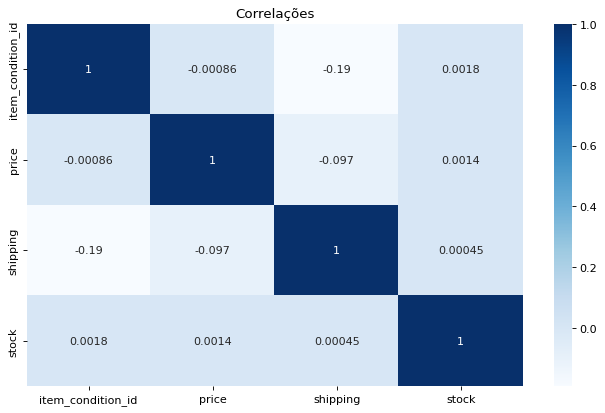

In [12]:
plt.figure(figsize=(10,6), dpi=80)
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlações')
plt.show()

Como foi observado no mapa de calor, o dataset possui pouca ou quase nenhuma correlação entre as variaveis numericas. Seria interessante transformar as variaveis categorias em variaveis numericas e observar novamente as correlações; além de também aplicar um modelo de regressão nesses dados transformados. Para isso irei utilizar um metodo de codificação booleano chamado get_dummie. 



In [13]:
df_temp =  pd.get_dummies(df[['main_cat','sub_cat_1','sub_cat_2']])

In [14]:
df_temp.shape

(1476204, 993)

A transformação das variaveis aumentou consideravelmente a dimensionalidade do dataset. Para tentar contornar esse problema, vou aplicar um PCA para tentar diminuir a dimencionalidade.

In [15]:
from sklearn.decomposition import PCA, IncrementalPCA

In [16]:
x = df_temp

In [21]:
df_temp.head()

,main_cat_Beauty,main_cat_Electronics,main_cat_Handmade,main_cat_Home,main_cat_Kids,main_cat_Men,main_cat_Other,main_cat_Sports & Outdoors,main_cat_Vintage & Collectibles,main_cat_Women,...,sub_cat_2_Women's Golf Clubs,sub_cat_2_Wool,sub_cat_2_Work & Safety,sub_cat_2_Wrap,sub_cat_2_Wristlet,sub_cat_2_Writing,sub_cat_2_Yarn,sub_cat_2_Yoga & Pilates,sub_cat_2_Zipper,sub_cat_2_iPad
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#pca = PCA()
#pca.fit(x)

A redução de dimensionalidade não está funcionando, pois está excedendo o uso de memoria RAM do Colab. Abaixo irei fazer alguns teste para tentar resolver.

In [ ]:
from scipy import sparse

In [ ]:
transformer = IncrementalPCA(n_components=7, batch_size=200)
transformer.partial_fit(x)

In [ ]:
x.shape

In [ ]:
n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components = 84,\
                                batch_size = None)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = \
    pd.DataFrame(data = X_train_incrementalPCA, index = train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_test)
X_validation_incrementalPCA = \
    pd.DataFrame(data = X_validation_incrementalPCA, index = validation_index)



## EXPERIMENTANDO MODELOS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

### Testando regressão linear

In [ ]:
X = train.drop(['name', 'item_description', 'price', 'main_cat', 'sub_cat_1', 'sub_cat_2'], axis=1)
y = train.price

X_std = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state=10)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)